# Convolution and Feature Maps — The Building Blocks of CNNs

## Step 1: Setting Up the PyTorch Environment


In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# Function for image visualization (original)
def plot_image(image_tensor, title=""):
    # Ensure tensor is on CPU and detached from gradients before converting to NumPy
    image_numpy = image_tensor.cpu().detach().numpy()
    plt.imshow(image_numpy, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

# Enhanced function to plot multiple feature maps in a grid
def plot_feature_maps(feature_maps_tensor, num_cols=3, main_title="Feature Maps"):
    """
    Plots multiple feature maps from a tensor.
    Assumes feature_maps_tensor is of shape (num_maps, height, width).
    """
    # Ensure tensor is on CPU and detached
    feature_maps_tensor = feature_maps_tensor.cpu().detach()

    num_maps = feature_maps_tensor.shape[0]
    # Adjust num_cols if there are fewer maps than default columns
    if num_maps < num_cols:
        num_cols = num_maps
    num_rows = (num_maps + num_cols - 1) // num_cols # Calculate rows needed

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 3, num_rows * 3.5)) # Increased height slightly
    # If only one map, axes might not be an array, handle this
    if num_maps == 1:
        axes = [axes]
    else:
        axes = axes.flatten()

    fig.suptitle(main_title, fontsize=16)

    for i in range(num_maps):
        ax = axes[i]
        fm_np = feature_maps_tensor[i].numpy() # Already detached and on CPU
        ax.imshow(fm_np, cmap='gray')
        ax.set_title(f"Map {i+1}")
        ax.axis('off')

    # Turn off unused subplots
    for j in range(num_maps, len(axes)):
        axes[j].axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make space for suptitle and prevent overlap
    plt.show()

## Step 2: Exploration of Convolutional Layers


Original Sample Image:
 tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])
Convolutional Filter:
 tensor([[ 1.,  0.],
        [ 0., -1.]])
Output Feature Map (after convolution):
 tensor([[-4., -4.],
        [-4., -4.]], grad_fn=<SqueezeBackward0>)


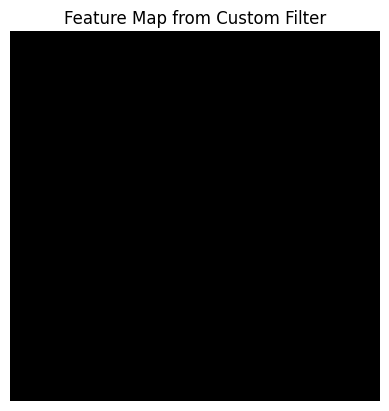

In [ ]:
# Sample image and a manually defined filter
sample_image_data = torch.tensor([[1, 2, 3], [4, 5, 6], [7, 8, 9]], dtype=torch.float32)
# This filter can detect diagonal patterns (e.g., top-left to bottom-right edges)
conv_filter_data = torch.tensor([[1, 0], [0, -1]], dtype=torch.float32)

# Create a Conv2d layer
# in_channels=1 (grayscale), out_channels=1 (one filter), kernel_size=2x2
conv_layer = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=2, stride=1, padding=0, bias=False)

# Manually set the weights of the convolutional layer to our defined filter
# torch.no_grad() is used because we are changing model parameters directly, not during training.
with torch.no_grad():
    # conv_layer.weight is (out_channels, in_channels, kernel_height, kernel_width)
    # For our case, it's (1, 1, 2, 2). So, weight[0][0] refers to the first (and only) filter.
    conv_layer.weight[0][0] = conv_filter_data

# Prepare the sample image for the Conv2d layer
# Expected input shape: (batch_size, in_channels, height, width)
sample_image_tensor = sample_image_data.view(1, 1, 3, 3)

# Apply the convolution operation
# output_feature_map will have shape (1, 1, 2, 2)
# H_out = (3 - 2)/1 + 1 = 2
# W_out = (3 - 2)/1 + 1 = 2
output_feature_map = conv_layer(sample_image_tensor)

print("Original Sample Image:\n", sample_image_data)
print("Convolutional Filter:\n", conv_filter_data)
print("Output Feature Map (after convolution):\n", output_feature_map.squeeze())

# Visualize the output feature map
# .squeeze() removes dimensions of size 1 (batch and channel) for plotting
plot_image(output_feature_map.squeeze(), title="Feature Map from Custom Filter")

## Step 3: Constructing a Simple ConvNet Layer


Shape of conv1 weights: torch.Size([3, 1, 3, 3])
Shape of conv1 bias: torch.Size([3])
Output from model shape: torch.Size([1, 3, 3, 3])


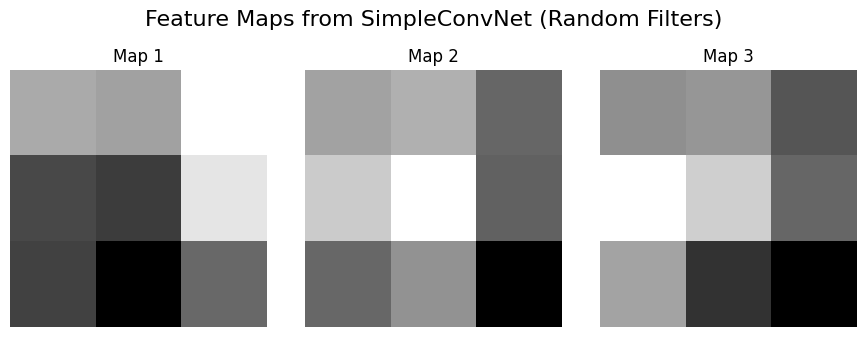

In [ ]:
# Define a simple convolutional network
class SimpleConvNet(nn.Module):
    def __init__(self):
        super(SimpleConvNet, self).__init__()
        # This convolutional layer has:
        # - 1 input channel (e.g., grayscale image)
        # - 3 output channels (meaning it will learn 3 different filters)
        # - A 3x3 kernel for each filter
        # - Stride of 1 and padding of 1 (preserves input spatial dimensions)
        # Weights and biases for these filters will be randomly initialized by PyTorch.
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=3, stride=1, padding=1, bias=True)

    def forward(self, x):
        x = self.conv1(x)
        return x

# Instantiate the network
model = SimpleConvNet()

# Print some information about the randomly initialized weights and biases
print("Shape of conv1 weights:", model.conv1.weight.shape) # (out_channels, in_channels, H_k, W_k)
# print("Conv1 weights (randomly initialized):\n", model.conv1.weight.data) # Optional: view weights
if model.conv1.bias is not None:
    print("Shape of conv1 bias:", model.conv1.bias.shape) # (out_channels)
    # print("Conv1 bias (randomly initialized):\n", model.conv1.bias.data) # Optional: view biases

# Set the model to evaluation mode (important for layers like BatchNorm, Dropout during inference)
# For a simple Conv2d layer, it doesn't change behavior but is good practice.
model.eval()

# The same sample_image_tensor from Step 2 (1, 1, 3, 3) is used as input
# We use torch.no_grad() as we are not training, only doing a forward pass for inference.
with torch.no_grad():
    output_from_model = model(sample_image_tensor)

# Output shape will be (batch_size, out_channels, height, width) -> (1, 3, 3, 3)
# H_out = (3 + 2*1 - 3)/1 + 1 = 3
# W_out = (3 + 2*1 - 3)/1 + 1 = 3
print("Output from model shape:", output_from_model.shape)

# Visualize the multiple feature maps
# Squeeze out the batch_size dimension (dim=0) for plotting.
# The result `feature_maps_viz` will have shape (out_channels, height, width) -> (3, 3, 3)
feature_maps_viz = output_from_model.squeeze(0)

plot_feature_maps(feature_maps_viz, num_cols=3, main_title="Feature Maps from SimpleConvNet (Random Filters)")